Created: 16/11/2022
<br>
Author: aleksander.grm@fpp.uni-lj.si

**XFoil for Python**

Use of program XFoil with Python interface, Web page: https://pypi.org/project/xfoil/
<br>
NACA profile, Web page: https://nasa.fandom.com/wiki/NACA_airfoil

In [1]:
import math as mat
import numpy as np
from xfoil import XFoil
from xfoil.model import Airfoil
import matplotlib.pyplot as mpl
from decimal import Decimal

# MatPlotLib set fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['DejaVu Serif']

# MatPlotLib set LaTeX use
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

In [2]:
# Generates N points of NACA 4 digit profile
#
# - M: chord height
# - P: chord x coordinate of max y point 
# - T: thickness
# - N: number of division point on one side

def NACA_4D_profile(M,P,T,N):

    # parametrization & x coordinate by cosine distribution
    t = np.linspace(0,1,N)
    xc = 0.5*(1 - np.cos(t*mat.pi))
    
    # thickness
    a0=0.2960; a1=-0.126; a2=-0.3516; a3=0.2834; a4=-0.1015;
    yt = np.zeros(N)
    for i in range(N):
        yt[i] = 5*T * (a0*xc[i]**0.5 + a1*xc[i] + a2*xc[i]**2 + a3*xc[i]**3 + a4*xc[i]**4)
    
    # symmetric profile
    if P < 1e-8:
        x = np.concatenate((np.flip(xc), xc))
        y = np.concatenate((np.flip(yt), -yt))
        
        return [x,y,Airfoil(x,y)]
        
    # asymmetric profile
    idxP = np.argmax(xc>P) # find position of P

    # chord line coordinate
    yc = np.zeros(N)
    dydx = np.zeros(N)
    for i in range(N):
        if i < idxP:
            yc[i] = M/P**2 * (2*P*xc[i] - xc[i]**2)
            dydx[i] = 2*M/P**2 * (P - xc[i])
        else:
            yc[i] = M/(1-P)**2 * (1 - 2*P + 2*P*xc[i] - xc[i]**2)
            dydx[i] = 2*M/(1-P)**2 * (P - xc[i])
        
    # Upper surface
    xU = np.zeros(N)
    yU = np.zeros(N)
    for i in range(N):
        th = mat.atan(dydx[i])
            
        xU[i] = xc[i] - yt[i]*mat.sin(th)
        yU[i] = yc[i] + yt[i]*mat.cos(th)
        
    # Lower surface
    xL = np.zeros(N)
    yL = np.zeros(N)
    for i in range(N):
        th = mat.atan(dydx[i])
            
        xL[i] = xc[i] + yt[i]*mat.sin(th)
        yL[i] = yc[i] - yt[i]*mat.cos(th)
     
    # profile coordinates
    x = np.concatenate((np.flip(xU), xL))
    y = np.concatenate((np.flip(yU), yL))
    
    return [x, y, Airfoil(x,y)]

In [3]:
# Runs simulation for specific
# - Angle of attack
# - gets cp distribution
def plot_profile(x, y, m, p, t, N):
    
    title = 'NACAXXXX profile  (m={:.2f}, p={:.2f}, t={:.2f}, N={:d})'.format(m,p,t,N)
    fig, ax = mpl.subplots()
    
    ax.plot(x,y)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid()
    ax.set_aspect('equal', 'box')
    ax.set_title(title)
    
    fig.tight_layout()
    fig.savefig('profile.pdf')

In [4]:
# Runs simulation for specific
# - Angle of attack
# - gets cp distribution
def run_single(xf, ang, Re, Re_str, p_name):
    if Re > 0: 
        xf.Re = Re;
        xf.max_iter = 40
    else: xf.Re = 0
        
    cl, cd, cm, cp = xf.a(ang)
    x, cpd = xf.get_cp_distribution()
    
    fig, ax = mpl.subplots()
    
    ax.plot(x,cpd)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$C_p$')
    ax.set_title(r'{:s}  ($\alpha={:3.1f}^\circ$, Re={:s})'.format(p_name,ang,Re_str))
    ax.grid()
    
    fig.tight_layout()
    fig.savefig('cp_distribution.pdf')

In [5]:
# Runs simulation for specific:
# - Reynolds
def run_interval(xf, int_d, Re, Re_str, p_name):
    if Re > 0:
        xf.Re = Re
        xf.max_iter = 40
        from decimal import Decimal
    else: xf.Re = 0
        
    a, cl, cd, cm, cp = xf.aseq(int_d[0], int_d[1], int_d[2])
    
    fig, ax = mpl.subplots()
    
    ax.plot(a,cl,'g', markersize=2, label='$C_L$')
    ax.plot(a,cd,'r', markersize=2, label='$C_D$')
    ax.plot(a,cp,'b', markersize=2, label='$C_p$')
    
    ax.set_xlabel('Angle of attack [$^\circ$]')
    ax.set_ylabel('')
    ax.grid()
    ax.set_title(r'{:s}  (Re={:s})'.format(p_name,Re_str))
    ax.legend()
       
    fig.tight_layout()
    fig.savefig('coefficients.pdf')

In [6]:
# Runs simulation for specific:
# - Reynolds
def bucket_diagram(xf, int_d, Re, Re_str, p_name):
    if Re > 0:
        xf.Re = Re
        xf.max_iter = 40
        from decimal import Decimal
    else: xf.Re = 0
        
    N = int((int_d[1] - int_d[0])/int_d[2])
    angs = np.linspace(int_d[0],int_d[1],N)
    
    cp_min = []
    for ang in angs:
        cl, cd, cm, cp = xf.a(ang)
        x, cpd = xf.get_cp_distribution()
        cp_min.append(np.min(cpd))
        
    fig, ax = mpl.subplots()
    
    ax.plot(cp_min,angs,'b', markersize=1)
    
    ax.set_xlabel(r'$C_p$')
    ax.set_ylabel(r'$\alpha$ [$^\circ$]')
    ax.set_title('Bucket Diagram ({:s} , Re={:s})'.format(p_name,Re_str))
    ax.grid()
    ax.invert_xaxis()
        
    fig.savefig('bucket_diagram.pdf')

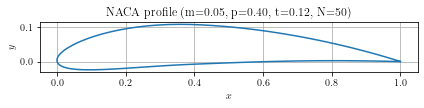

In [7]:
# Generate NACA 4 digit profile
# M = 0; P = 0; T = 0.12; # NACA0012
M = 0.05; P = 0.4; T = 0.12; # NACA0412
#M = 0.1; P = 0.4; T = 0.12; # NACA1412
p_name = 'NACA{:d}{:d}{:d}'.format(mat.floor(M*10), mat.floor(P*10), mat.floor(T*100))

N = 50; # number of division points
[x,y,naca_profile] = NACA_4D_profile(M,P,T,N)
plot_profile(x,y,M,P,T,N)

In [ ]:
# Start XFoil simulations
Re = 1e6
interval = [-20,20,0.5]

xf = XFoil()
xf.airfoil = naca_profile

# Reynolds string v potenci na 10
(sign, digits, exponent) = Decimal(Re).as_tuple()
Re_str = r'$10^{:d}$'.format(len(digits) + exponent - 1)

# run simulations
run_single(xf, 5, Re, Re_str, p_name)
bucket_diagram(xf, interval, Re, Re_str, p_name)
run_interval(xf, interval, Re, Re_str, p_name)